In [182]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio

%matplotlib widget

In [183]:
json_folder = r"C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoJson"
img_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\Naver'
tiff_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoTiff'

In [184]:
files = glob.glob(os.path.join(tiff_folder,'*.tif'))
files

['C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTif

In [185]:
target_courseName = '오너스'

#### 이미지를 읽어온다 Raterio활용. crs를 5179로

In [186]:
out_tiff = [ x for x in files if 'L14' in x and target_courseName in x][0]

In [187]:
import rasterio
import cv2

with rasterio.open(out_tiff, mode='r+') as dataset:
  image_org = dataset.read()
  image_org = image_org.transpose(1, 2, 0)

In [188]:
dataset.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

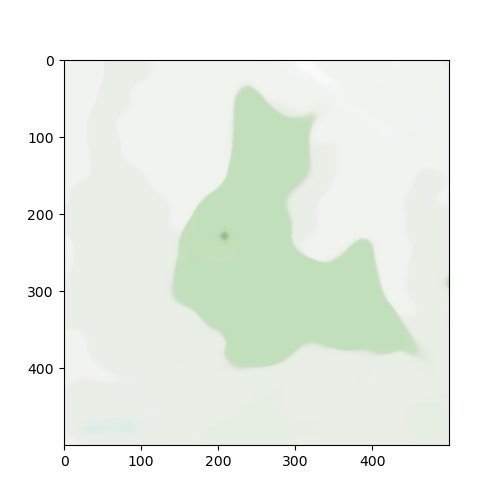

In [189]:
image = cv2.medianBlur(image_org,31)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(image)

In [190]:
## Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

## Mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# 65,  41, 223
#  67,  48, 218
#  68,  38, 206]
# mask = cv2.inRange(hsv, (57, 38, 73), (80, 55,217)) # green
# mask = cv2.inRange(hsv, (67, 47, 217), (69, 49,219))
# mask = cv2.inRange(hsv, (24, 29, 217), (76, 77,221))
# (hMin = 65 , sMin = 34, vMin = 126), (hMax = 69 , sMax = 90, vMax = 227)
# (hMin = 64 , sMin = 30, vMin = 191), (hMax = 71 , sMax = 49, vMax = 233)
mask = cv2.inRange(hsv, (50,30,151), (68, 101,255))
image2 = cv2.bitwise_and(image, image, mask = mask)

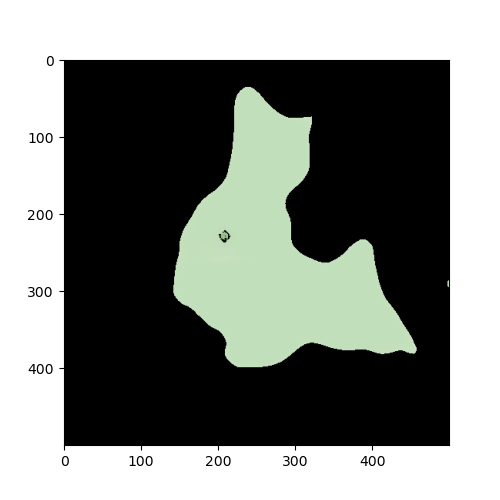

In [191]:
plt.figure(figsize=(5,5))
plt.imshow(image2)
plt.axis('on')
plt.show()

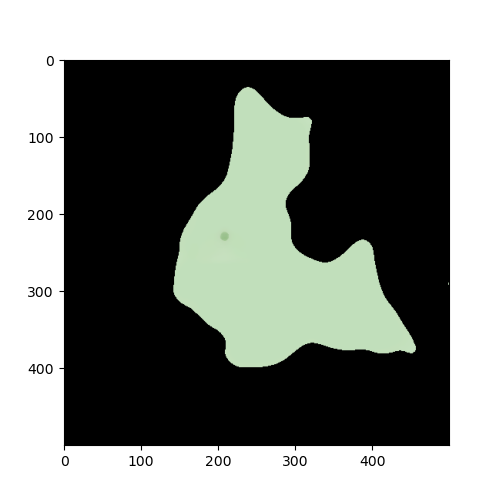

In [192]:
im1_blurred = cv2.medianBlur(image2 ,11)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(im1_blurred)

In [193]:
import numpy as np 

pixel_values = im1_blurred.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(im1_blurred.shape)

mask = labels.reshape(im1_blurred.shape[:2]).astype(np.uint8)

if np.where(centers == [0,0,0])[0][0] == 1:
  mask = np.logical_not(mask).astype(np.uint8)

In [194]:
plt.imshow(mask, cmap = 'gray')

In [195]:
contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [196]:
len(contours)

2

In [197]:
approx_contours = []

for c in contours:
    epsilon = 0.005*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)
    
    if cv2.contourArea(c) > 5000:
        approx_contours.append(approx)
    print(c.shape,approx.shape)

(4, 1, 2) (2, 1, 2)
(1104, 1, 2) (23, 1, 2)


In [198]:
len(approx_contours)

1

In [199]:
image_copy = image_org.copy()
# c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=approx_contours, contourIdx=-1, color=(255,1,1), thickness=2, lineType=cv2.LINE_AA)

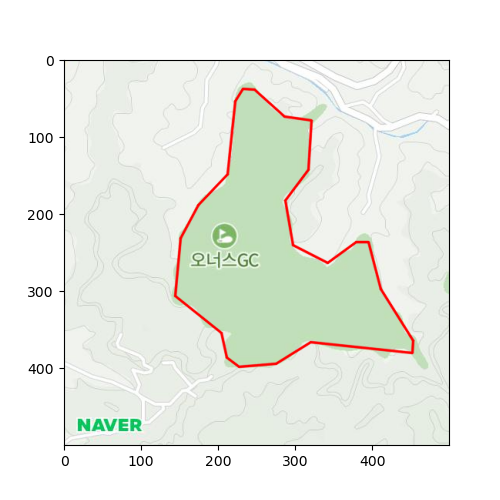

In [200]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(image_copy)

In [201]:
contours = [approx_contours[-1]]

def convert_latlon(a,dataset_):
    return dataset_.xy(a[1],a[0])

In [202]:
from shapely.geometry import Polygon


con_geo = []
for i,contour in enumerate(contours):
    con_single = np.squeeze(np.apply_along_axis(lambda p: convert_latlon(p, dataset), -1, contour))
    
    try:
        con_single = Polygon(con_single)
        con_geo.append(con_single)
    except:
        pass

In [203]:
gdf = gpd.GeoSeries(con_geo, crs=int(4326))
gdf = gpd.GeoDataFrame(geometry=gdf)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [204]:
gdf['Name']= 'Contour_' + gdf.index.astype(str)
gdf['Client'] = os.path.split(out_tiff)[-1].split('L')[0]

gdf['Course'] = '전체'
gdf['Hole'] = 0

gdf['Type'] = '전면'





In [205]:
import fiona
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
  gdf.to_file(os.path.join(json_folder,os.path.split(out_tiff)[-1].split('L')[0]+'_전면_'+'.geojson'), driver='GeoJSON')